In [2]:
def create_alluvial_data(df, time_cols):
    """
    Convert DataFrame with community classifications to alluvial input format
    for multiple timepoints
    
    Parameters:
    df: DataFrame with community classifications
    time_cols: list of column names representing timepoints
    
    Returns:
    list: Array of dictionaries ready for alluvial.plot
    """
    results = []
    
    # Create transition matrices for consecutive timepoints
    for i in range(len(time_cols) - 1):
        current_time = time_cols[i]
        next_time = time_cols[i + 1]
        
        result = {}
        source_communities = sorted(df[current_time].unique())
        target_communities = sorted(df[next_time].unique())
        
        # Initialize the nested dictionary
        for source in source_communities:
            source_label = f"{source}_{current_time}"
            result[source_label] = {}
            for target in target_communities:
                target_label = f"{target}_{next_time}"
                result[source_label][target_label] = 0.0
        
        # Count transitions between communities
        for source in source_communities:
            source_label = f"{source}_{current_time}"
            source_group = df[df[current_time] == source]
            
            for target in target_communities:
                target_label = f"{target}_{next_time}"
                count = len(source_group[source_group[next_time] == target])
                if count > 0:
                    result[source_label][target_label] = float(count)
        
        # Remove empty source communities
        result = {k: v for k, v in result.items() 
                 if any(val > 0 for val in v.values())}
        
        results.append(result)
    
    return results


In [3]:
def create_alluvial_data_with_intermediates(df, time_cols):
    """
    Convert DataFrame with community classifications to alluvial input format
    including indirect transitions through intermediate communities
    
    Parameters:
    df: DataFrame with community classifications
    time_cols: list of 3 column names representing timepoints
    
    Returns:
    tuple: (direct_transitions, intermediate_transitions)
        - direct_transitions: list of direct transition matrices
        - intermediate_transitions: list of transition matrices through each T2 community
    """
    if len(time_cols) != 3:
        raise ValueError("This function requires exactly 3 timepoints")
    
    # Get direct transitions (T1->T2 and T2->T3)
    direct_transitions = create_alluvial_data(df, time_cols)
    
    # Get indirect transitions through each T2 community
    intermediate_transitions = []
    t2_communities = sorted(df[time_cols[1]].unique())
    
    for t2_community in t2_communities:
        # Filter nodes that passed through this T2 community
        intermediate_nodes = df[df[time_cols[1]] == t2_community]
        
        result = {}
        source_communities = sorted(intermediate_nodes[time_cols[0]].unique())
        target_communities = sorted(intermediate_nodes[time_cols[2]].unique())
        
        # Initialize the nested dictionary
        for source in source_communities:
            source_label = f"{source}_{time_cols[0]}"
            result[source_label] = {}
            for target in target_communities:
                target_label = f"{target}_{time_cols[2]}"
                result[source_label][target_label] = 0.0
        
        # Count transitions
        for source in source_communities:
            source_label = f"{source}_{time_cols[0]}"
            source_group = intermediate_nodes[intermediate_nodes[time_cols[0]] == source]
            
            for target in target_communities:
                target_label = f"{target}_{time_cols[2]}"
                count = len(source_group[source_group[time_cols[2]] == target])
                if count > 0:
                    result[source_label][target_label] = float(count)
        
        # Remove empty source communities
        result = {k: v for k, v in result.items() 
                 if any(val > 0 for val in v.values())}
        
        intermediate_transitions.append((t2_community, result))
    
    return direct_transitions, intermediate_transitions

In [4]:
# Create a sample data frame with 20 rows which occupy different communities at t1, t2, and t3
import pandas as pd
import numpy as np
import random

# Create a sample data frame with 20 rows
df = pd.DataFrame(np.arange(0,24), columns=['id'])

# df['size'] = np.random.randint(1, 100, df.shape[0])
df['T1'] = np.floor(df['id']/8).astype(int)
df['T2'] = df['T1'].apply(lambda x: x if random.random() < 0.2 else np.random.randint(0, 3))
df['T3'] = df['T2'].apply(lambda x: x if random.random() < 0.2 else np.random.randint(0, 3))
direct_transitions, intermediate_transitions = create_alluvial_data_with_intermediates(df, ['T1', 'T2', 'T3'])
print(direct_transitions)
print(intermediate_transitions)
t1_t2_data = direct_transitions[0]
t2_t3_data = direct_transitions[1]

[{'0_T1': {'0_T2': 4.0, '1_T2': 2.0, '2_T2': 2.0}, '1_T1': {'0_T2': 2.0, '1_T2': 2.0, '2_T2': 4.0}, '2_T1': {'0_T2': 1.0, '1_T2': 2.0, '2_T2': 5.0}}, {'0_T2': {'0_T3': 5.0, '1_T3': 0.0, '2_T3': 2.0}, '1_T2': {'0_T3': 0.0, '1_T3': 6.0, '2_T3': 0.0}, '2_T2': {'0_T3': 6.0, '1_T3': 3.0, '2_T3': 2.0}}]
[(np.int64(0), {'0_T1': {'0_T3': 2.0, '2_T3': 2.0}, '1_T1': {'0_T3': 2.0, '2_T3': 0.0}, '2_T1': {'0_T3': 1.0, '2_T3': 0.0}}), (np.int64(1), {'0_T1': {'1_T3': 2.0}, '1_T1': {'1_T3': 2.0}, '2_T1': {'1_T3': 2.0}}), (np.int64(2), {'0_T1': {'0_T3': 2.0, '1_T3': 0.0, '2_T3': 0.0}, '1_T1': {'0_T3': 3.0, '1_T3': 0.0, '2_T3': 1.0}, '2_T1': {'0_T3': 1.0, '1_T3': 3.0, '2_T3': 1.0}})]


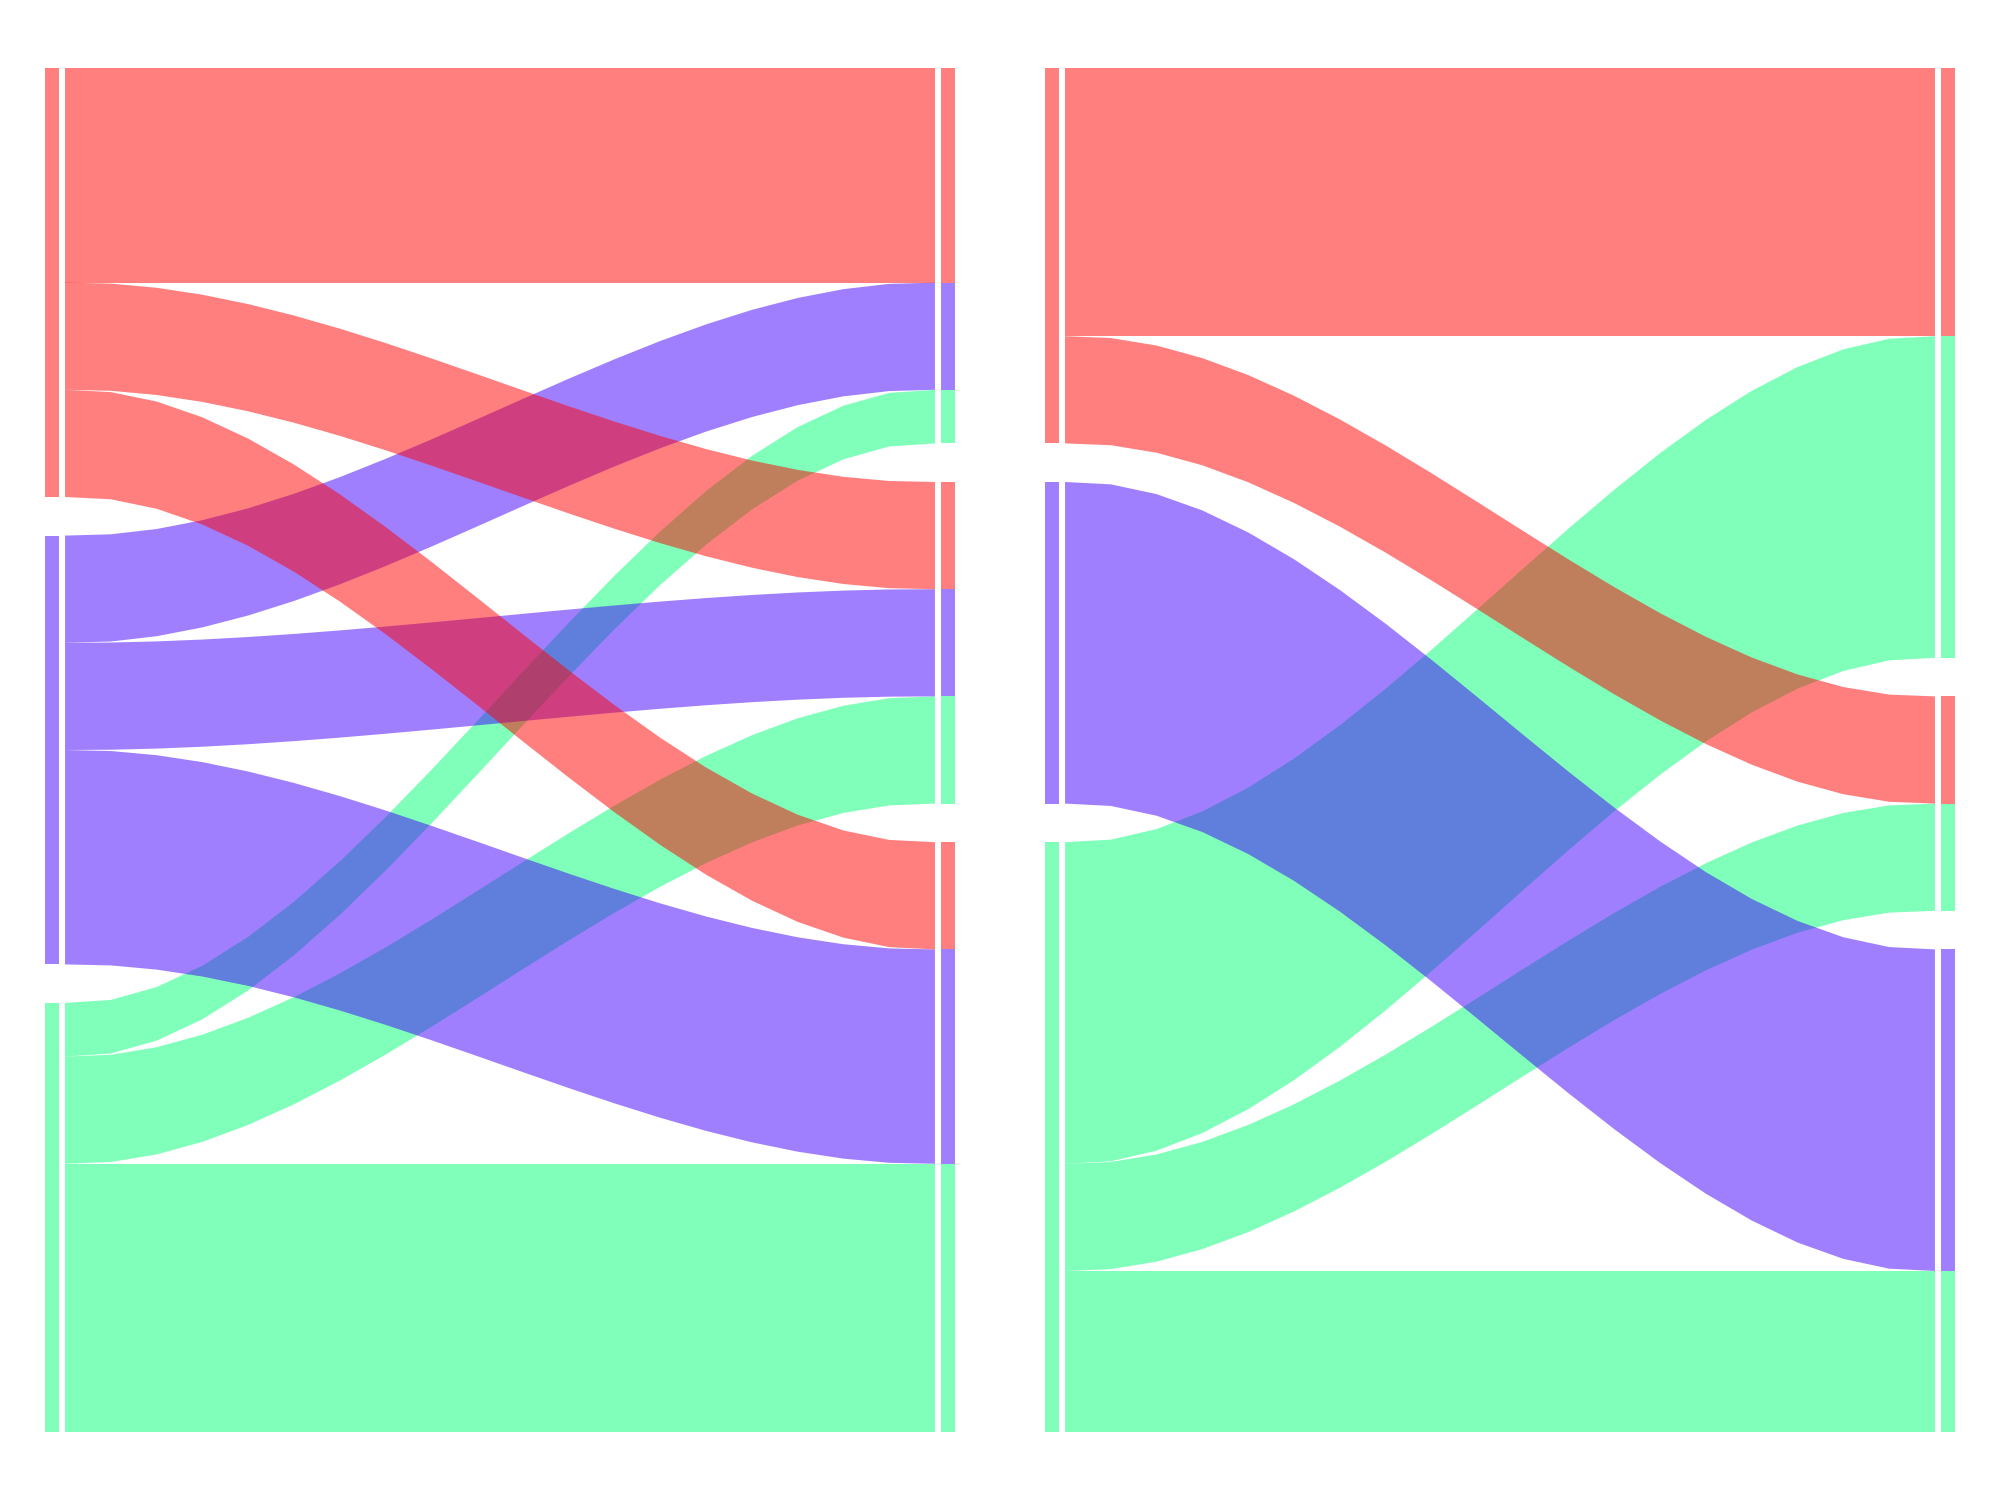

In [5]:
import sys
if 'alluvial' in sys.modules:
  del sys.modules['alluvial']
import alluvial
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

# input_data_12 ={'c': {'cc': 1.3,  'aa': 0.9,  'bb': 0.3,}, # sum=2.5
#                 'a': {'cc': .7,    'aa': 2.6,    'bb': .7,}, # sum=4
#                 'b': {'cc': 0.5,  'aa': 0.5,  'bb': 2,}} # sum=3



ax1 = alluvial.plot(t1_t2_data)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig('alluvial12.png', bbox_inches='tight', pad_inches=0)
ax2 = alluvial.plot(t2_t3_data)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

plt.savefig('alluvial23.png', bbox_inches='tight', pad_inches=0)
# Close the figures to prevent them from displaying
plt.close(ax1.figure)
plt.close(ax2.figure)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# alluvial.plot(t1_t2_data, ax=ax1)
# ax1.set_title('T1 → T2 Transitions')
# alluvial.plot(t2_t3_data, ax=ax2)
# ax2.set_title('T2 → T3 Transitions')

# plt.tight_layout()
# plt.savefig('community_transitions.png')
# plt.close()

import sys
from PIL import Image

images = [Image.open(x) for x in ['alluvial12.png', 'alluvial23.png']]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

y_offset = 0
for im in images:
  new_im.paste(im, (y_offset,0))
  y_offset += im.size[0]

new_im.save('test.jpg')
display(new_im)

In [33]:
t1_t3_0 = intermediate_transitions[0][1]
t1_t3_1 = intermediate_transitions[1][1]
t1_t3_2 = intermediate_transitions[2][1]

# Calculate total flows for each transition
def calculate_total_flow(transition_dict):
    total = 0
    for source in transition_dict:
        for target in transition_dict[source]:
            total += transition_dict[source][target]
    return total

total_flows = [
    calculate_total_flow(t1_t3_0),
    calculate_total_flow(t1_t3_1),
    calculate_total_flow(t1_t3_2)
]

ax3 = alluvial.plot(t1_t3_0)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig('alluvial13_0.png', bbox_inches='tight', pad_inches=0)

ax4 = alluvial.plot(t1_t3_1)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig('alluvial13_1.png', bbox_inches='tight', pad_inches=0)

ax5 = alluvial.plot(t1_t3_2)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig('alluvial13_2.png', bbox_inches='tight', pad_inches=0)

plt.close(ax3.figure)
plt.close(ax4.figure)
plt.close(ax5.figure)

images = [Image.open(x) for x in ['alluvial13_0.png', 'alluvial13_1.png', 'alluvial13_2.png']]
widths, heights = zip(*(i.size for i in images))
heights = [h - 30 for h in heights]
max_width = max(widths)//3
# Calculate base height using the maximum flow
tot_flow = sum(total_flows)
base_height = sum(heights) //3

# Calculate proportional heights
proportional_heights = [int(base_height * (flow / tot_flow)) for flow in total_flows]

new_im = Image.new('RGB', (max_width, base_height), 'white')

y_offset = 50
for im, prop_height in zip(images, proportional_heights):
    # Resize image maintaining aspect ratio but using proportional height
    aspect_ratio = im.size[0] / im.size[1]
    new_height = prop_height
    new_width = int(new_height * aspect_ratio)
    resized_im = im.resize((max_width, new_height))
    
    new_im.paste(resized_im, (0, y_offset))
    y_offset += new_height - 20  # Add 40px gap between images

new_im.save('intermediate.jpg')
# display(new_im)
# display(new_im)

In [7]:
intermediate_transitions

[(np.int64(0),
  {'0_T1': {'0_T3': 2.0, '2_T3': 2.0},
   '1_T1': {'0_T3': 2.0, '2_T3': 0.0},
   '2_T1': {'0_T3': 1.0, '2_T3': 0.0}}),
 (np.int64(1),
  {'0_T1': {'1_T3': 2.0}, '1_T1': {'1_T3': 2.0}, '2_T1': {'1_T3': 2.0}}),
 (np.int64(2),
  {'0_T1': {'0_T3': 2.0, '1_T3': 0.0, '2_T3': 0.0},
   '1_T1': {'0_T3': 3.0, '1_T3': 0.0, '2_T3': 1.0},
   '2_T1': {'0_T3': 1.0, '1_T3': 3.0, '2_T3': 1.0}})]

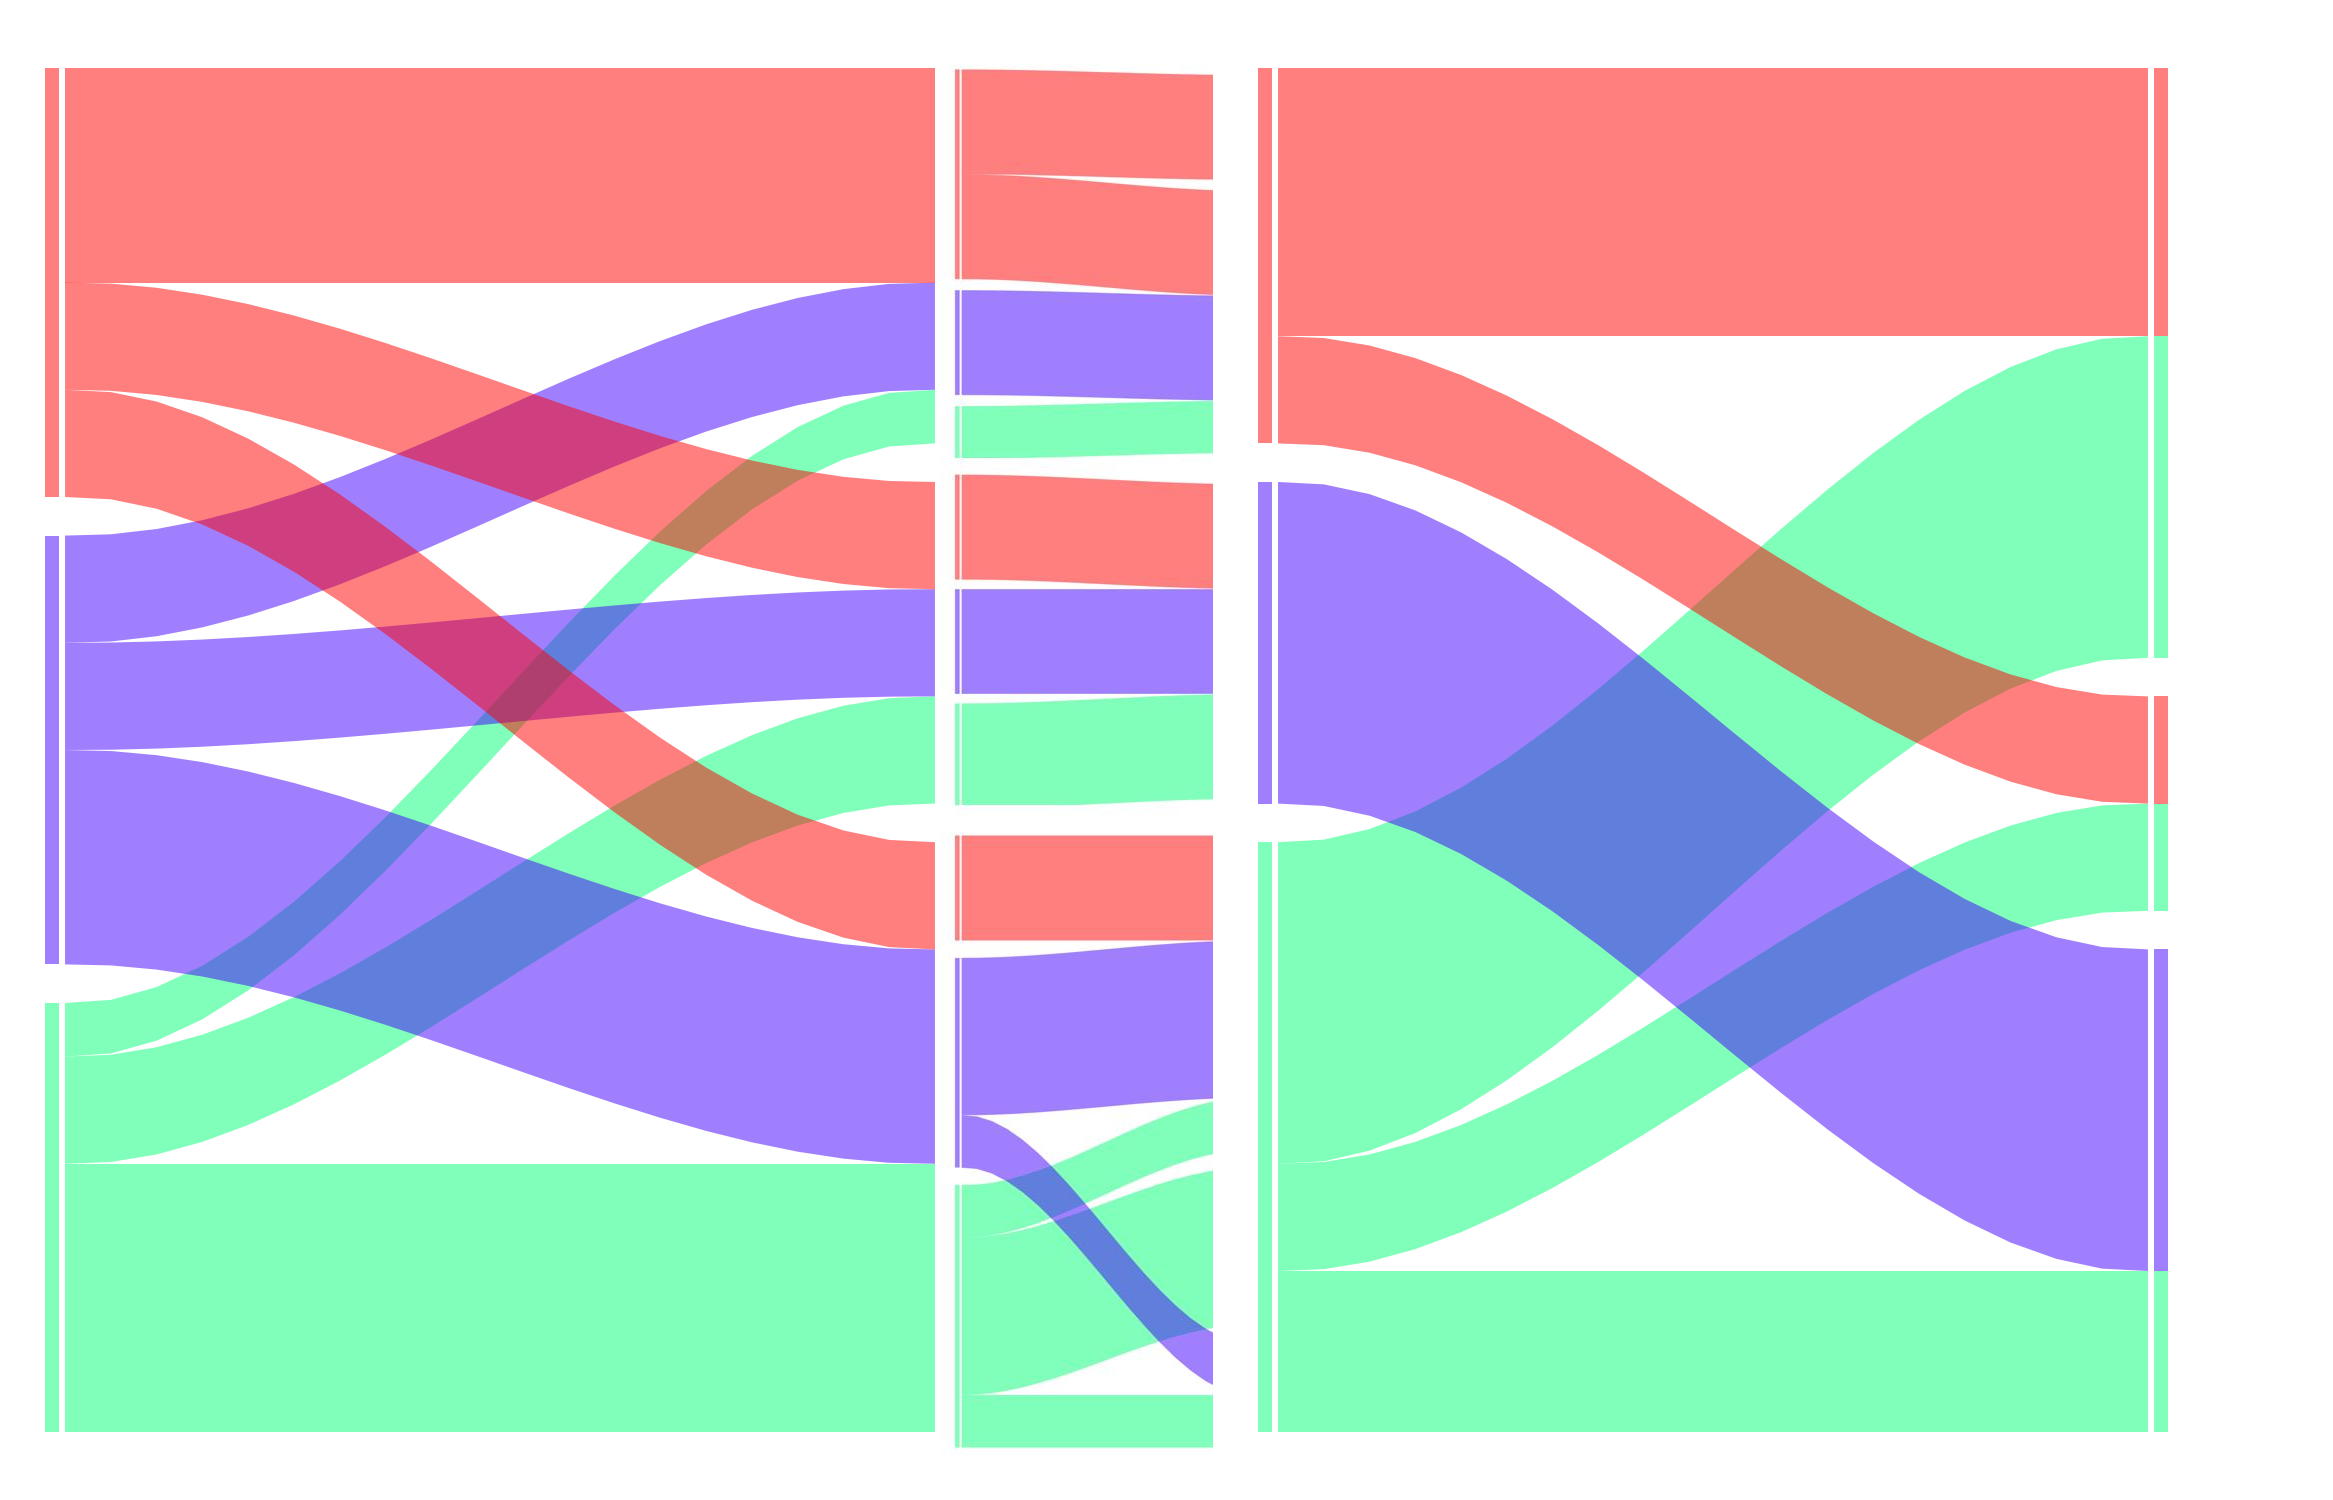

In [38]:
images = [Image.open(x) for x in ['alluvial12.png', 'intermediate.jpg', 'alluvial23.png']]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

# Create a white background image
new_im = Image.new('RGBA', (total_width, max_height), 'white')

x_offset = 0
for im in images:
  new_im.paste(im, (x_offset,0))
  x_offset += im.size[0]-60


new_im.save('composite.png')
display(new_im)
